# CUSTOM FEATURES

In [1]:
import numpy as np
import import_ipynb
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
import statistics as st
import pandas as pd
import math
from collections import Counter

In [2]:
def get_pswm(training,upstream_position,downstream_position):
    """
    Build a Position Specific Weight Matrix (PSWM) from protein sequences.
    """
    training.reset_index(inplace=True)  # Reset index for convenience and ensure compatibility with the function
    # Extract the subsequence around the cleavage site for each protein
    training=training.query("Class=='Positive'")
    
    for index,row in training.iterrows():
        sequence_to_recover=row["Sequence"]
        cleavage_position=int(row["SPEnd"])
        training.loc[index, "Sequence"] = sequence_to_recover[cleavage_position-upstream_position:cleavage_position+downstream_position]
  
    # Initialize PSWM dictionary with one entry per amino acid
    pswm = {"A": "", "R": "", "N": "", "D": "", "C": "", "Q": "", "E": "", "G": "", "H": "", "I": "", "L": "", "K": "", "M": "", "F": "", "P": "", "S": "", "T": "", "W": "", "Y": "", "V": ""}
    position=[]

    # Background frequencies from SwissProt
    swiss_frequencies = { "A" : 0.0825 , "R" : 0.0552 , "N" : 0.0406 , "D" : 0.0546 , "C" : 0.0138 , "Q" : 0.0393, "E" : 0.0671, "G" : 0.0707, "H" : 0.0227, "I" : 0.0590 ,"L" : 0.0964, "K" : 0.0579, "M" : 0.0241, "F" : 0.0386, "P" : 0.0474, "S" : 0.0665, "T" : 0.0536, "W" : 0.0110, "Y" : 0.0292 , "V": 0.0685}
   
    # Initialize counts with 1 (pseudocounts)
    for i in range(len(training.loc[1,"Sequence"])):
        position.append(1)
    for key in pswm:
        pswm[key]=position[:]
        
    #update all the counts for each position and aminoacid
    i=0
    for index, row in training.iterrows():
        i=0
        for aa in row["Sequence"]:
            if aa=='X':
                pass
            else:
                pswm[aa][i]+=1
            i+=1
    
    N=len(training) #number of sequences
    
    # Compute log-odds scores for the PSWM
    for key in pswm:
        for i in range(len(pswm[key])):
            pswm[key][i]=math.log((pswm[key][i]/(N+20))/swiss_frequencies[key])
    return pswm

In [3]:
# function to count efficiently aminoacids frequencies
def selected_residue_composition(sequence):
    # define aminoacids order
    aa_order = "CDMNR"
    counts_vector=[]
    length=len(sequence)
    for aa in aa_order:
        counts_vector.append(sequence.count(aa)/length)
    return counts_vector

In [4]:
#function that computes the VonHeijne matrix
def vonheijne_feature(matrix , seq): 
    
    # Iterate among all sequences of the set 
    
    validation_scores = []      # List that only contains the scores
    pos = 0                 # Counter for window size tracking
    aa = 0                  # Index that moves along the sequence
    tmp_score = 0           # Initialize window score
    max_window_score = -math.inf 
        
    end = min(90, len(seq)) # We end iterating on the sequence when we reach the 90th aa or when the 
                                # sequence ends (sequence length < 90 aa)
        
    while aa < end - 14:    # Iteration on the sequence
        while pos <= 14:    # Iteration while the window is less than the fixed window size
            
            try:            # Try statement to handle aminoacids not found in the matrix
                tmp_score += matrix[seq[aa + pos]][pos] # computing the score of the window
                
            except KeyError :
                tmp_score += 0
            pos +=1         # Increasing the window size counter
            
        if tmp_score > max_window_score: # Checking if the actual window has a better score than the previous one
            max_window_score = tmp_score
        
        aa += 1             # Increase the starting point
        pos = 0             # Reset the window size
        tmp_score = 0       # Reset window score

            
    return max_window_score


In [5]:
def get_scale_features (seq, scale ,window): 
        
    ''' This function returns the features (max score and average score) of a chosen scale for a specific sequence. You can use a personalized 
    dictionary of scores or a one inside ProtParamData. You can check all the ProtParamData scales using the command dir(ProtParamData) A legend of each 
    param argument is given at the beginning of this file'''

    sequence = ProteinAnalysis(seq) 
    if type(scale)==dict:   
        scale_result = sequence.protein_scale(scale, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(scale, len(seq), edge=1)
    else:
        param_dict = getattr(ProtParamData, scale)
        scale_result = sequence.protein_scale(param_dict, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(param_dict, len(seq), edge=1)
    max_value=max(scale_result)
    mean_value=st.mean(scale_result)
    return max_value , mean_value

In [6]:
#features to use from the feature selection:
#features_to_use=['VhonHeijne', 'C', 'tm_tendency_max', 'chou_fasman_h_mean', 'max_miyazawa_mean', 'D', 'T', 'R', 'chou_fasma_b_max', 'N', 'flexibility_max', 'punta_max', 'bulkiness_mean', 'M', 'argos_max']
def get_selected_features(set_n, matrix, window):
    all_features_result=[]
    #bulkiness dictionary for prot param function
    bulkiness = { "A": 11.500  , "R": 14.280  , "N": 12.820  ,"D": 11.680  ,"C": 13.460  ,"Q": 14.450  ,"E": 13.570  ,"G":  3.400  , "H": 13.690  , "I": 21.400  , "L": 21.400  , "K": 15.710  , "M": 16.250  , "F": 19.800  , "P": 17.430  , "S":  9.470  , "T": 15.770  , "W": 21.670  , "Y": 18.030  ,  "V": 21.570 }
    #transmembrane tendency dictionary for prot param function recovered from https://web.expasy.org/protscale/pscale/Transmembranetendency.html
    tm_tendency_custom =     {'A':  0.380,     'R': -2.570,    'N': -1.620,     'D': -3.270,    'C': -0.300,     'Q': -1.840,     'E': -2.900,    'G': -0.190,    'H': -1.440,     'I':  1.970,     'L':  1.820,     'K': -3.460,     'M':  1.400,     'F':  1.980,    'P': -1.440,    'S': -0.530,     'T': -0.320,     'W':  1.530,     'Y':  0.490,    'V':  1.400  }
    argos = getattr(ProtParamData, "ag")
    #Miyazawa hydrophobicity inverse
    miyazawa = getattr(ProtParamData, "mi")
    #Flexibility scale
    flexibility = getattr(ProtParamData, "Flex")
    #Knowledge-based membrane-propensity scale from 1D_Helix in MPtopo databases (Punta-Maritan, 2003)
    punta = {"A": -0.17, "L": -0.28, "R": 0.37, "K": 0.32, "N": 0.18, "M": -0.26, "D": 0.37, "F": -0.41, "C": -0.06, "P": 0.13, "Q": 0.26, "S": 0.05, "E": 0.15, "T": 0.02, "G": 0.01, "W": -0.15, "H": -0.02, "Y": -0.09, "I": -0.28, "V": -0.17}
    #Normalized frequency of alpha-helix (Chou-Fasman, 1978b)
    chou_fasman_h = {"A": 1.42, "L": 1.21, "R": 0.98, "K": 1.16, "N": 0.67, "M": 1.45, "D": 1.01, "F": 1.13, "C": 0.70, "P": 0.57, "Q": 1.11, "S": 0.77, "E": 1.51, "T": 0.83, "G": 0.57, "W": 1.08, "H": 1.00, "Y": 0.69, "I": 1.08, "V": 1.06}
    #Normalized frequency of beta-sheets (Chou-Fasman, 1978b)
    chou_fasman_b = {"A": 0.83, "L": 1.30, "R": 0.93, "K": 0.74, "N": 0.89, "M": 1.05, "D": 0.54, "F": 1.38, "C": 1.19, "P": 0.55, "Q": 1.10, "S": 0.75, "E": 0.37, "T": 1.19, "G": 0.75, "W": 1.37, "H": 0.87, "Y": 1.47, "I": 1.60, "V": 1.70}
    
    features_to_use=[(tm_tendency_custom , "max"), (chou_fasman_h , "mean"), (miyazawa , "mean"), (chou_fasman_b, "max"), (flexibility , "max"), (punta , "max"), (bulkiness , "mean"), (argos , "max") ]

    #extract each sequence in the set
    for seq in set_n:
        seq=seq.replace("X" , "")
        seq=seq.replace("U" , "C")
        seq_features = [] 
        #extract each feature type for each sequence
        for scale in features_to_use: #extract the max_value and avg_value of scale features
            max_value,avg_value = get_scale_features(seq, scale[0], window)
            if scale[1]=="max":
                seq_features.append(max_value)
            else:
                seq_features.append(avg_value)
        vonhejine=vonheijne_feature(matrix, seq) #get the von heijne feature for that sequence
        composition=selected_residue_composition(seq) #get the selected aminaocid composition frequency
        #append all the features of that specific sequence
        seq_features.append(vonhejine)
        seq_features=seq_features+composition
        #add these feature to the total feature list
        all_features_result.append(seq_features) # aggiungo la riga al risultato finale
    X = np.array(all_features_result) #transform the list that contains all the features in an array
    
    return X


In [7]:
#features to use from the feature selection:
features_to_use=['VhonHeijne', 'C', 'tm_tendency_max', 'chou_fasman_h_mean', 'max_miyazawa_mean', 'D', 'T', 'R', 'chou_fasma_b_max', 'N', 'flexibility_max', 'punta_max', 'bulkiness_mean', 'M', 'argos_max']

In [8]:
# compute the feature set:
dataset=pd.read_csv("../Data_Preparation/train_bench.tsv", sep='\t')
training=dataset.query("Set != 'Benchmark'")
benchmark=dataset.query("Set == 'Benchmark'")

mat=get_pswm(training ,13 ,2 )
train_matrix=get_selected_features(training["Sequence"] , mat , 15)

#training vector:
tr_vector_neg_pos = training["Class"]
tr_vector_proper = tr_vector_neg_pos.map({"Positive": 1, "Negative": 0})
tr_target_vector = tr_vector_proper.to_numpy()
#benchmark:
bn_vector_neg_pos = benchmark["Class"]
bn_vector_proper = bn_vector_neg_pos.map({"Positive": 1, "Negative": 0})
bn_target_vector = bn_vector_proper.to_numpy()

print(tr_target_vector)
print(bn_target_vector)

x_benchmark=get_selected_features(benchmark["Sequence"] , mat , 15)

[1 1 1 ... 0 0 0]
[0 0 0 ... 1 1 1]


# SVM TESTING 


In [9]:
import numpy as np
from sklearn.metrics import matthews_corrcoef
#! pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import PredefinedSplit
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef , confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
#create the pipeline
pipeline = Pipeline([("scaler" , StandardScaler()) , ("svm" , SVC(cache_size=1500))])
#predict the benchmark set
classifier=pipeline.set_params(svm__C=2.687775805186727, svm__gamma=0.012249546394282136, svm__kernel='rbf').fit(train_matrix , tr_target_vector) 
bench_pred = pipeline.predict(x_benchmark)
#compute the mcc
mcc = matthews_corrcoef(bn_target_vector , bench_pred)
print(f"MCC on testing set: {mcc}")

MCC on testing set: 0.8119764250066371


[[1756   31]
 [  41  178]]


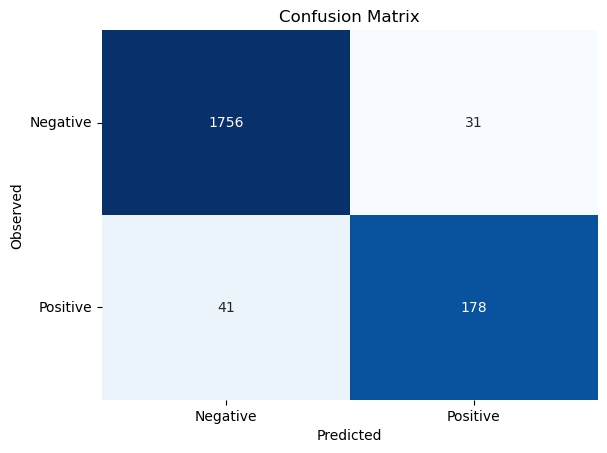

In [12]:
conf_mat = confusion_matrix(bn_target_vector , bench_pred)
print(conf_mat)
sns.heatmap(
        conf_mat,
        annot=True,
        cmap="Blues",
        fmt="d",
        cbar=False,
        vmax = 200      
    )
plt.xlabel("Predicted")
plt.ylabel("Observed")  
plt.title("Confusion Matrix")  
plt.xticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.yticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"], rotation=0)
plt.show()